In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf

In [2]:
os.chdir(os.path.join('..','data'))
df = pd.read_csv('mj-clean.csv',parse_dates=[5])
df = df[df['date']<np.datetime64('2014-05-31')]
start_date = min(df['date'])
year = np.datetime64(1,'Y')
df['year'] = ((df['date'] - start_date)).astype('timedelta64[D]')/365
# parse the date otherwise the date will be interpreted as object

In [3]:
df.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon,year
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870,0.0
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820,0.0
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258,0.0
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521,0.0
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983,0.0


In [4]:
np.shape(df)

(147070, 11)

In [5]:
groups=df.groupby('quality')

In [57]:
dailies = {}
start = min(df)
for name,group in groups:
    sub_groups= group[['date','ppg','year']].groupby('date').aggregate(np.mean)
    dailies[name] = sub_groups

In [58]:
def plt_ppg(quality='high',enddate='31May2014'):
    plt.scatter(dailies[quality].index,dailies[quality]['ppg'],alpha=0.5)
    plt.ylim(0,20)
    plt.xticks(rotation=90)

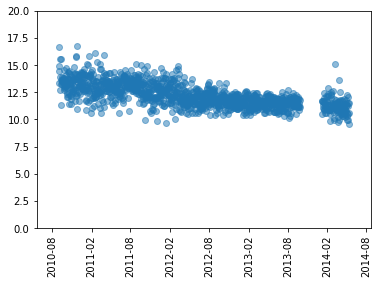

In [59]:
plt_ppg()

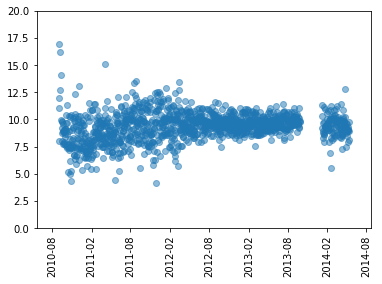

In [60]:
plt_ppg(quality='medium')

11.3 Linear regression
---

In [61]:
def pearson_coeff(x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    xmean = np.mean(x)
    ymean = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    xi = [(val-xmean)/std_x for val in x] 
    yi = [(val-ymean)/std_y for val in y]
    
    return sum(xi*np.transpose(yi))/len(x)

def leastSquares(xs,ys):
    r = pearson_coeff(xs,ys)
    slope = r*(np.std(ys)/np.std(xs))
    intercept = np.mean(ys)-slope*np.mean(xs)
    return slope,intercept

def fitLine(xs,slope,intercept):
    fit_xs = np.sort(xs)
    fit_ys = fit_xs*slope+intercept
    return fit_xs,fit_ys

def fit_and_plt(xs,ys,xlabel,ylabel):
    slope,intercept = leastSquares(xs,ys)
    fit_xs,fit_ys = fitLine(xs,slope,intercept)
    plt.plot(fit_xs,fit_ys,color='black')
    plt.scatter(xs,ys,alpha=0.5,color='cyan')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    return slope,intercept

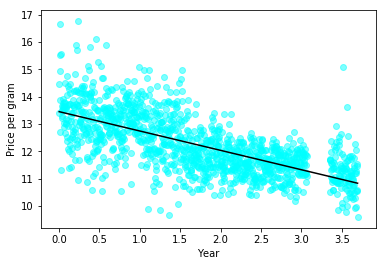

(-0.7077363104080909, 13.449644313420912)

In [62]:
year = dailies['high']['year']
ppg = dailies['high']['ppg']
fit_and_plt(year,ppg,'Year','Price per gram')

In [12]:
formula = 'ppg~year'
result = smf.ols(formula,data=dailies['high']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     989.7
Date:                Sun, 09 Dec 2018   Prob (F-statistic):          3.69e-160
Time:                        15:26:17   Log-Likelihood:                -1510.1
No. Observations:                1241   AIC:                             3024.
Df Residuals:                    1239   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4496      0.045    296.080      0.000      13.361      13.539
year          -0.7077      0.022    -31.460      0.000      -0.752      -0.664
==============================================================================
Omnibus:                       56.254   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.992
Skew:                           0.252   Prob(JB):                     9.76e-29
Kurtosis:                       4.497   Cond. No.                         4.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The
model seems like a good linear fit for the data; nevertheless, linear regression
is not the most appropriate choice for this data:

- First, there is no reason to expect the long-term trend to be a line or
any other simple function. In general, prices are determined by supply
and demand, both of which vary over time in unpredictable ways.
- Second, the linear regression model gives equal weight to all data, recent
and past. For purposes of prediction, **we should probably give more
weight to recent data.**
- Finally, one of the assumptions of linear regression is that the residuals
are uncorrelated noise. With time series data, this assumption is often
false because successive values are correlated.

12.4 Moving averages
----

Regression is one way to extract the trend from a series, as we saw in the
previous section. But if the trend is not a simple function, a good alternative
is a moving average. A moving average divides the series into overlapping
regions, called windows, and computes the average of the values in each
window.

One of the simplest moving averages is the rolling mean, which computes
the mean of the values in each window. For example, if the window size is
3, the rolling mean computes the mean of values 0 through 2, 1 through 3, 2
through 4, etc.

In [13]:
series = np.arange(0,10)
series = pd.Series(series)

In [14]:
series.rolling(3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

In the DataFrames we have used so far, these dates are absent; the index
skips days with no data. For the analysis that follows, we need to represent
this missing data explicitly. We can do that by \reindexing" the DataFrame:

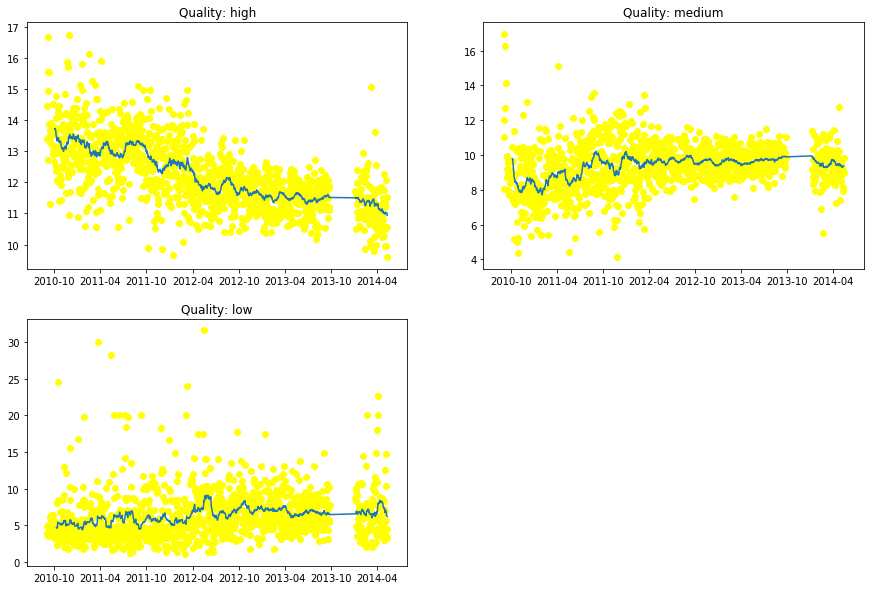

In [15]:
# subplot(nrows, ncols, index, **kwargs)
fig = plt.figure()
fig.set_size_inches(15,10)

# add a automated to plot n by n number of subplots with titles and axis labels

qualities  = df['quality'].unique()
count = 1
for quality in qualities:
    ax = plt.subplot(int(str(22)+str(count)))
    
    x_axis = dailies[quality].index.date
    roll_mean = dailies[quality]['ppg'].rolling(30).mean() #new version pandas implementation
    ax.plot(x_axis,roll_mean)
    ax.set_title('Quality: '+quality)
    ax.scatter(x_axis,dailies[quality]['ppg'],color='yellow')
    count +=1

The noise in the low quality is more than medium and high is having the lowest noise.

The rolling mean seems to do a good job
of smoothing out the noise and extracting the trend. The first 29 values are
nan, and wherever there’s a missing value, it’s followed by another 29 nans.
There are ways to fill in these gaps, but they are a minor nuisance.

An alternative is the **exponentially-weighted moving average (EWMA)**,
which has two advantages

First, as the name suggests, it computes a
weighted average where the most recent value has the highest weight and
the weights for previous values drop off exponentially. 

Second, the pandas
implementation of EWMA handles missing values better.

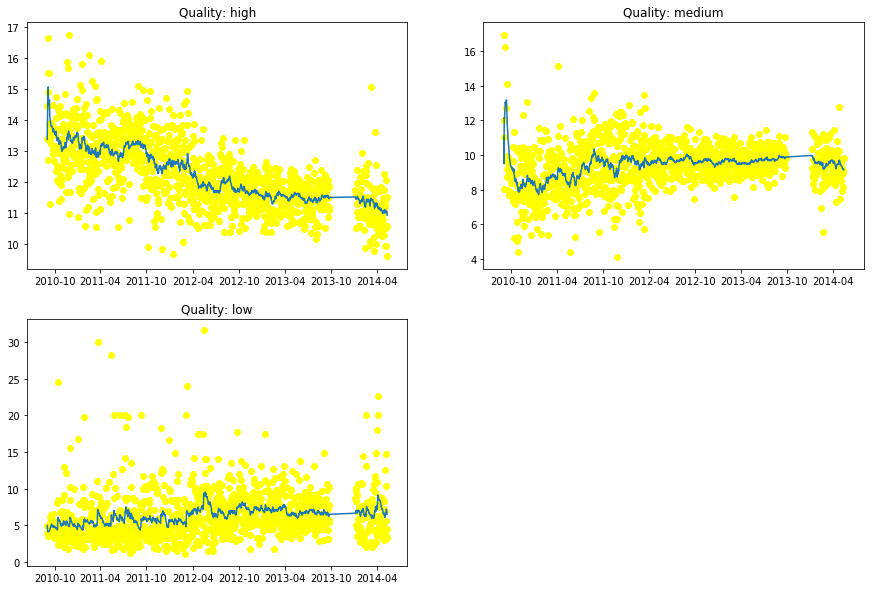

In [16]:
# subplot(nrows, ncols, index, **kwargs)
fig = plt.figure()
fig.set_size_inches(15,10)

# add a automated to plot n by n number of subplots with titles and axis labels

qualities  = df['quality'].unique()
count = 1
for quality in qualities:
    ax = plt.subplot(int(str(22)+str(count)))
    
    x_axis = dailies[quality].index.date
    roll_mean = dailies[quality]['ppg'].ewm(span=30).mean()  # new pandas version implementation
    ax.plot(x_axis,roll_mean)
    ax.set_title('Quality: '+quality)
    ax.scatter(x_axis,dailies[quality]['ppg'],color='yellow')
    count +=1

12.5 Missing Values
----

In the DataFrames we have used so far, these dates are absent; the index
skips days with no data. For the analysis that follows, we need to represent
this missing data explicitly

In [17]:
# examples for pd.date_rage
start = '01/11/2018'
end = '02/12/2018'
pd.date_range(start=end,end=end,freq='D')

DatetimeIndex(['2018-02-12'], dtype='datetime64[ns]', freq='D')

In [18]:
pd.date_range(min(dailies['high'].index),max(dailies['high'].index))

DatetimeIndex(['2010-09-02', '2010-09-03', '2010-09-04', '2010-09-05',
               '2010-09-06', '2010-09-07', '2010-09-08', '2010-09-09',
               '2010-09-10', '2010-09-11',
               ...
               '2014-05-04', '2014-05-05', '2014-05-06', '2014-05-07',
               '2014-05-08', '2014-05-09', '2014-05-10', '2014-05-11',
               '2014-05-12', '2014-05-13'],
              dtype='datetime64[ns]', length=1350, freq='D')

In [19]:
dates = pd.date_range(min(dailies['high'].index),max(dailies['high'].index)) # reindexing the dates
reindexed = dailies['high'].reindex(dates)
len(reindexed)

1350

In [20]:
len(dailies['high'])

1241

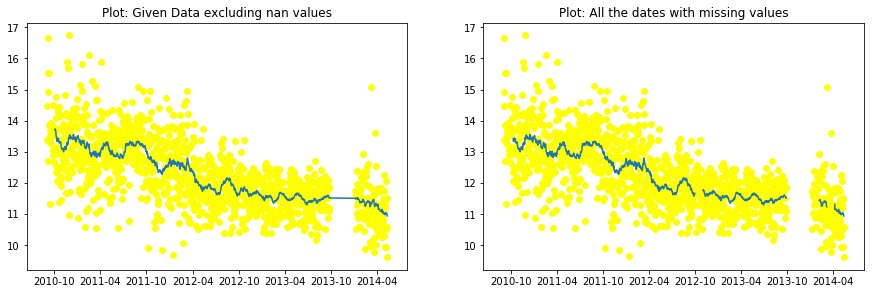

In [21]:
fig = plt.figure()
fig.set_size_inches(15,10)
dataframes = [dailies['high'],reindexed]
# add a automated to plot n by n number of subplots with titles and axis labels
label = ['Given Data excluding nan values','All the dates with missing values']
count = 1
for dataframe in dataframes:
    ax = plt.subplot(int(str(22)+str(count)))
    
    x_axis = dataframe.index.date
    roll_mean = dataframe['ppg'].rolling(30).mean()  # new pandas version implementation
    ax.plot(x_axis,roll_mean)
    ax.set_title('Plot: '+label[count-1])
    ax.scatter(x_axis,dataframe['ppg'],color='yellow')
    count +=1

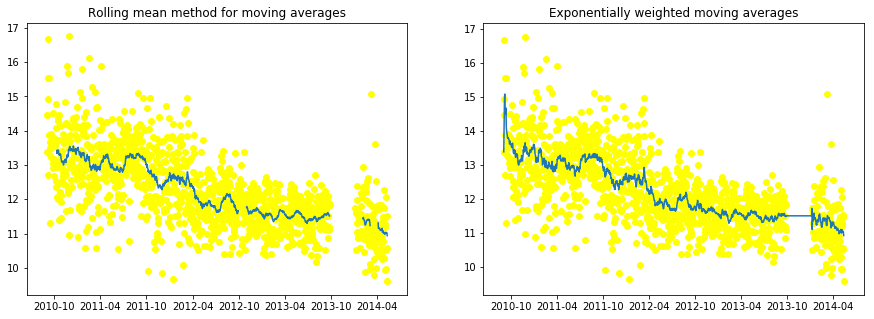

In [22]:
# comparison of rolling mean and exponentially weighted moving average
fig = plt.figure()
fig.set_size_inches(15,5)

ax1 = plt.subplot(121)
x_axis = reindexed.index.date
roll_mean = reindexed['ppg'].rolling(30).mean()  # new pandas version implementation
ax1.plot(x_axis,roll_mean)
ax1.set_title('Rolling mean method for moving averages')
ax1.scatter(x_axis,reindexed['ppg'],color='yellow')

ax2 = plt.subplot(122)
x_axis = reindexed.index.date
emwa = reindexed['ppg'].ewm(span=30).mean()  # new pandas version implementation
ax2.plot(x_axis,emwa)
ax2.set_title('Exponentially weighted moving averages')
ax2.scatter(x_axis,reindexed['ppg'],color='yellow')

A simple and common way to fill missing data is to use a moving average.
The Series method fillna does just what we want:

In [23]:
reindexed['ppg'].fillna(emwa,inplace=True)
reindexed.head()

,ppg,year
2010-09-02,13.384186,0.000000
2010-09-03,14.459588,0.002740
2010-09-04,14.923333,0.005479
2010-09-05,16.667500,0.008219
2010-09-06,15.537500,0.010959


Wherever reindexed.ppg is nan, fillna replaces it with the corresponding
value from ewma. The inplace flag tells fillna to modify the existing Series
rather than create a new one.

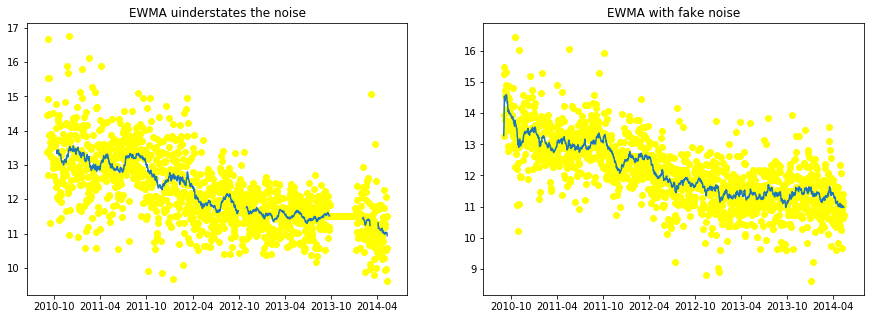

In [24]:
fig = plt.figure()
fig.set_size_inches(15,5)
ax3 = plt.subplot(121)
x_axis = reindexed.index.date
emwa = reindexed['ppg'].ewm(span=30).mean()  # new pandas version implementation
ax3.plot(x_axis,roll_mean)
ax3.set_title('EWMA uinderstates the noise')
ax3.scatter(x_axis,reindexed['ppg'],color='yellow')

#Drawback of emwa fill na method: it understates the noise of the data
resid = (reindexed['ppg']-emwa).dropna()
fake_data = emwa + np.random.choice(resid,replace=True,size=len(reindexed))

ax4 = plt.subplot(122)
x_axis = fake_data.index.date
ax4.plot(x_axis,fake_data.ewm(span=30).mean())
ax4.set_title('EWMA with fake noise')
ax4.scatter(x_axis,fake_data.values,color='yellow')

resid contains the residual values, not including days when ppg is nan.
fake_data contains the sum of the moving average and a random sample of
residuals. Finally, fillna replaces nan with values from fake_data.

The filled data is visually similar to the actual
values. Since the resampled residuals are random, the results are different
every time; later we’ll see how to characterize the error created by missing
values

12.6 Serial Correlation
------


Serial correlation is a term used in statistics to describe the relationship between observations of the same variable over specific periods of time. If a variable's serial correlation is measured to be zero, then it means there is no correlation, and each of the observations are independent of one another. Conversely, if a variable's serial correlation skews towards one, it means that the observations are serially correlated, and **that future observations are affected by past values**. Essentially, a variable that is serially correlated has a pattern and isn't random.

Source: Investopedia.com
https://www.investopedia.com/terms/s/serial-correlation.asp

In [74]:
series = pd.Series([1,2,3,4,5,6,7,8])
past_values = series.shift(1)[1:]
past_values.values

array([1., 2., 3., 4., 5., 6., 7.])

In [75]:
future_values = series[1:]
future_values.values

array([2, 3, 4, 5, 6, 7, 8])

In [77]:
stats.pearsonr(past_values.values,future_values.values)[0]
# this means that the future values are affected by the past values and they have positive impact on the future value.

1.0

In [28]:
def serial_corr(series,lag=1):
    a = series[lag:]
    b = series.shift(lag)[lag:]
    return stats.pearsonr(a,b)[0]

In [29]:
qualities = df['quality'].unique()
for quality in qualities:
    print(quality,serial_corr(dailies[quality]['ppg'],lag=1))

high 0.485229376194738
medium 0.16006429989181087
low 0.11657497441101058


In any time series with a long-term trend, we expect to see strong serial
correlations; for example, if prices are falling, we expect to see values above
the mean in the first half of the series and values below the mean in the
second half.

**Serial correlation for residuals:**

In [30]:
for quality in qualities:
    dates = pd.date_range(min(dailies[quality].index),max(dailies[quality].index)) # reindexing the dates
    reindexed = dailies[quality].reindex(dates)
    ewma1 = reindexed['ppg'].ewm(span=30).mean()
    resid = reindexed['ppg']-ewma1
    resid= resid.dropna()
    print(quality,serial_corr(resid,lag=1))

high -0.01405935769751534
medium -0.015855370072941688
low 0.046274834127289034


These values are small,
indicating that there is little or no one-day serial correlation in this series.

To check for weekly, monthly, and yearly seasonality, I ran the analysis again
with different lags

In [31]:
for quality in qualities:
    dates = pd.date_range(min(dailies[quality].index),max(dailies[quality].index)) # reindexing the dates
    reindexed = dailies[quality].reindex(dates)
    ewma1 = reindexed['ppg'].ewm(span=30).mean()
    resid = reindexed['ppg']-ewma1
    resid= resid.dropna()
    for period in [1,7,30,365]:
        print('Quality: ',quality,' | period: ',period,' | corr: ',serial_corr(resid,lag=period))
    print('******************************')

Quality:  high  | period:  1  | corr:  -0.01405935769751534
Quality:  high  | period:  7  | corr:  0.008466504161818827
Quality:  high  | period:  30  | corr:  0.010823195025872905
Quality:  high  | period:  365  | corr:  0.07350282044121192
******************************
Quality:  medium  | period:  1  | corr:  -0.015855370072941688
Quality:  medium  | period:  7  | corr:  -0.046265304372122264
Quality:  medium  | period:  30  | corr:  -0.005034104161842449
Quality:  medium  | period:  365  | corr:  0.04766108069140311
******************************
Quality:  low  | period:  1  | corr:  0.046274834127289034
Quality:  low  | period:  7  | corr:  -0.021749063237782525
Quality:  low  | period:  30  | corr:  0.010022470177415387
Quality:  low  | period:  365  | corr:  -0.029094444450118682
******************************


In the next section we’ll test whether these correlations are statistically significant (they are not), but at this point we can tentatively conclude that
there are no substantial seasonal patterns in these series, at least not with
these lags.

12.7 Auto-correlation
----
Here we check the serial correlation of the residuals.

In [32]:
import statsmodels.tsa.stattools as smtsa
acf = smtsa.acf(resid,nlags=365,unbiased=True)
acf[0],acf[1],acf[7],acf[30],acf[365]

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(1.0,
 0.046305454547662966,
 -0.021782580292409853,
 0.01017554848792893,
 -0.029004989307094563)

In [33]:
def eval_cdf(value,series):
    count =0
    for x in series:
        if x <= value:
            count += 1
    return count/len(series)

def compute_cdf(series):
    x = sorted(list(series))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

def percentile(p,series):
    series, cdfs = compute_cdf(series)
    if p < min(cdfs):
        p = min(cdfs)
    return series[cdfs.index(max([cdf for cdf in cdfs if cdf <=p]))]

In [34]:
# simulate the serial correlation of residuals 
def simulateAutoCorrelation(data,iters=1001,nlags=40):
    acfs = []
    for _ in range(iters):
        resample = np.random.choice(data,replace=True,size=len(resid))
        acf_sample = smtsa.acf(resample,nlags=nlags,unbiased=True)[1:]
        acfs.append(acf_sample)
    highs = []
    lows = []
    for col in range(np.shape(acfs)[1]):
        column = acfs[:][col]
        highs.append(percentile(0.95,column))
        lows.append(percentile(0.05,column))
    return lows,highs

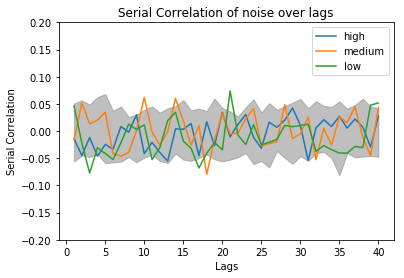

In [35]:
lows,highs = simulateAutoCorrelation(resid)

plt.title('Serial Correlation of noise over lags')
for quality in qualities:
    dates = pd.date_range(min(dailies[quality].index),max(dailies[quality].index)) # reindexing the dates
    reindexed = dailies[quality].reindex(dates)
    ewma1 = reindexed['ppg'].ewm(span=30).mean()
    resid = reindexed['ppg']-ewma1
    resid= resid.dropna()
    acf = smtsa.acf(resid,nlags=40,unbiased=True)
    lags = np.arange(1,41)
    plt.plot(lags,acf[1:],label=quality)

plt.fill_between(lags,lows,highs,color='gray',alpha=0.5)
plt.xlabel('Lags')
plt.ylim(-0.2,0.2)
plt.ylabel('Serial Correlation')
plt.legend()

The grey area in the plot above shows normal variability. Anything that falls outside this area is significant correlation. But here not many are lying outside the area. So hence we say that the serial correlation of the given data is not having any **Seasonality** (Periodic variation, possibly including daily, weekly,
monthly, or yearly cycles)

(-0.2, 0.2)

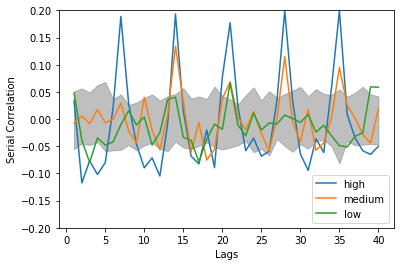

In [36]:
# simulation of data to see seasonal patterns
for quality in qualities:
    frisat = (dailies[quality].index.dayofweek ==4) | (dailies[quality].index.dayofweek ==5)
    simulated_data = dailies[quality].copy()
    simulated_data['ppg'][frisat] += np.random.uniform(0,2,size=frisat.sum())
    
    dates = pd.date_range(min(dailies[quality].index),max(dailies[quality].index)) # reindexing the dates
    reindexed = simulated_data.reindex(dates)
    # fitting the data with moving averages
    ewma2 = reindexed['ppg'].ewm(span=30).mean()
    resid = reindexed['ppg']-ewma2
    resid= resid.dropna()
    acf = smtsa.acf(resid,nlags=40,unbiased=True)
    lags = np.arange(1,41)
    plt.plot(lags,acf[1:],label=quality)
  
plt.fill_between(lags,lows,highs,color='gray',alpha=0.5)
plt.xlabel('Lags')
plt.ylabel('Serial Correlation')
plt.legend()
plt.ylim(-0.2,0.2)

We can clearly see that there is seasonality in the data we created.We can see there is significant correlation in weekends. (mulitple of 7)

shows autocorrelation functions for prices with this simulated seasonality.

As expected, the correlations are highest when the lag is
a multiple of 7. For high and medium quality, the new correlations are statistically significant. For low quality they are not, because residuals in this
category are large; 
**the effect would have to be bigger to be visible through
the noise.**

In [37]:
ewm = dailies['high']['ppg'].ewm(span=30).mean()  # predicted as per exponentially weighted moving averages
resid = dailies['high']['ppg'] - ewm

12.8 Prediction
-----

Predicting the time series data.

There will be 3 sources of error -
sampling error - The estimates might be different if we resample the data again.
To quantify the sampling error, we will resample the data for n iterations, then compute the 90% CI.


Random Variation - there is lot of random variation in the observed values.


**simulate the linear models for each resampled data**
The resampled data is based on initial linear model prediction + resampled(noise)
-> this is an assumption made while generating samples in the book.

In [38]:
# we can predict from the model we got
def GenerateSimplePrediction(df,years):
    n= len(years)
    Intercept = np.ones(n)
    result = smf.ols('ppg~year',data=df).fit()
    d = dict(year=years)
    predict_df = pd.DataFrame(d)
    return result.predict(predict_df)


years = np.linspace(0,5,num=len(dailies['high']))
GenerateSimplePrediction(dailies['high'],years)

0       13.449644
1       13.446791
2       13.443937
3       13.441083
4       13.438229
5       13.435375
6       13.432522
7       13.429668
8       13.426814
9       13.423960
10      13.421107
11      13.418253
12      13.415399
13      13.412545
14      13.409691
15      13.406838
16      13.403984
17      13.401130
18      13.398276
19      13.395423
20      13.392569
21      13.389715
22      13.386861
23      13.384007
24      13.381154
25      13.378300
26      13.375446
27      13.372592
28      13.369739
29      13.366885
          ...    
1211     9.993722
1212     9.990868
1213     9.988015
1214     9.985161
1215     9.982307
1216     9.979453
1217     9.976600
1218     9.973746
1219     9.970892
1220     9.968038
1221     9.965184
1222     9.962331
1223     9.959477
1224     9.956623
1225     9.953769
1226     9.950916
1227     9.948062
1228     9.945208
1229     9.942354
1230     9.939501
1231     9.936647
1232     9.933793
1233     9.930939
1234     9.928085
1235     9

In [39]:
def SimulateLinearModels(df,iters=101,resid=resid):
    results= []
    fake_df= df.copy()
    formula = 'ppg~year'
    result = smf.ols(formula,data=df).fit()
    
    for _ in range(iters):
        fake_data= result.fittedvalues + np.random.choice(result.resid,replace=True,size=len(result.resid))
        fake_df['ppg'] =fake_data
        result = smf.ols('ppg~year',data=fake_df).fit()
        results.append(result)
    return results

results = SimulateLinearModels(dailies['high']) #this contains the linear models generated from fake data
# Assuming the prediction estimates to be correct and variation in the noise only

In [50]:
def GeneratePrediction(results,n=100,add_resid=True):
    prediction = []
    years = np.linspace(0,5,num=n)
    d = dict(year=years)
    predict_df = pd.DataFrame(d)
    for result in results:
        p = result.predict(predict_df)
        if add_resid:
            p += np.random.choice(result.resid,replace=True,size=n)
        prediction.append(p)
    return np.array(prediction)

In [51]:
# accouting the variation in estimates for slope and intercept
sampling_error = GeneratePrediction(results,add_resid=False)  

# accounting the random variation in the data + the sampling error
random_error=np.array(GeneratePrediction(results))

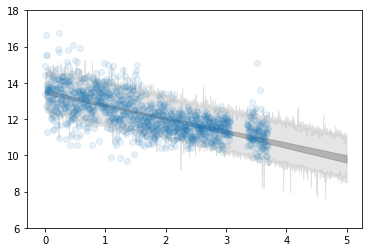

In [56]:
def plot_predictions(CI,predictions,years,alpha=0.2,color='gray'):
    low_ci = (100-CI)/(2*100)
    high_ci = low_ci+CI/100
    low,high= [],[]
    for i in range(np.shape(predictions)[1]):
        low.append(percentile(low_ci,predictions[:,i]))
        high.append(percentile(high_ci,predictions[:,i]))
    plt.fill_between(years,low,high,color=color,alpha=alpha)
    plt.ylim(6,18)
    

plot_predictions(90,random_error,years,alpha=0.2) 
plot_predictions(90,sampling_error,years,alpha=0.5)
year = dailies['high']['year']
ppg = dailies['high']['ppg']
plt.scatter(year,ppg,alpha=0.1)

**SUMMARY**


1. SAMPLE ERROR -  The dark area shows the 90% confidence interval for the sampling error for the estimates of the slopes and intercepts  we simulate different data from the given data and fit the line for each data set.

2. RANDOM ERROR - The lighter area is denotes the 90% Confidence interval for the random error. Which considers the predicted values from the different models that we simulated + the random noise added to the data.

Here the assumptions made are - 
- the estimates for slope and intercept that was used for prediction dont change over time, remain constant. (the parameters of the model dont change over time.)
- and also the distribution of the residuals

